In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score


In [31]:
df = pd.read_csv('../Dataset/SeoulBikeData.csv', encoding='ISO-8859-1')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [32]:
df.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

## 1. Exploring Correlations Between Features

Let's examine features that we expect to be correlated with each other:
- **Temperature and Dew Point Temperature**: Dew point is related to temperature
- **Temperature and Humidity**: Often inversely related
- **Visibility and Rainfall**: Rain reduces visibility
- **Solar Radiation and Temperature**: Solar radiation affects temperature

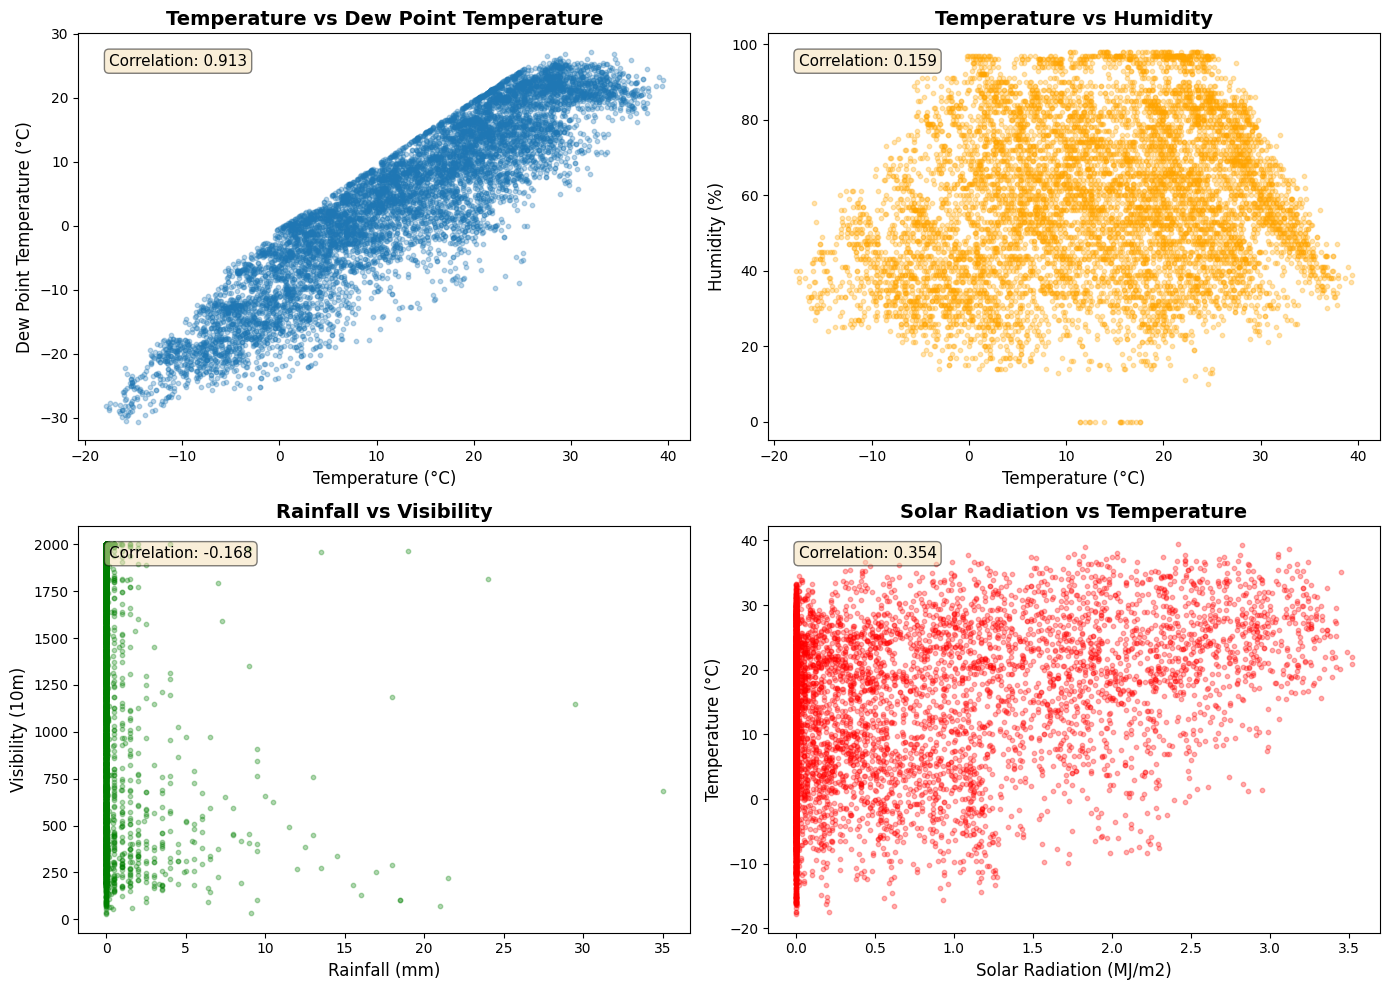


Summary of Feature-to-Feature Correlations:
Temperature vs Dew Point Temperature: 0.913 (Strong positive)
Temperature vs Humidity: 0.159 (Moderate negative)
Rainfall vs Visibility: -0.168 (Weak negative)
Solar Radiation vs Temperature: 0.354 (Moderate positive)


In [45]:
# Create a figure with subplots for feature-to-feature correlations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Temperature vs Dew Point Temperature (Expected: Positive correlation)
axes[0, 0].scatter(df['Temperature(°C)'], df['Dew point temperature(°C)'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Temperature (°C)', fontsize=12)
axes[0, 0].set_ylabel('Dew Point Temperature (°C)', fontsize=12)
axes[0, 0].set_title('Temperature vs Dew Point Temperature', fontsize=14, fontweight='bold')
correlation_1 = df['Temperature(°C)'].corr(df['Dew point temperature(°C)'])
axes[0, 0].text(0.05, 0.95, f'Correlation: {correlation_1:.3f}', 
                transform=axes[0, 0].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Temperature vs Humidity (Expected: Negative correlation)
axes[0, 1].scatter(df['Temperature(°C)'], df['Humidity(%)'], alpha=0.3, s=10, color='orange')
axes[0, 1].set_xlabel('Temperature (°C)', fontsize=12)
axes[0, 1].set_ylabel('Humidity (%)', fontsize=12)
axes[0, 1].set_title('Temperature vs Humidity', fontsize=14, fontweight='bold')
correlation_2 = df['Temperature(°C)'].corr(df['Humidity(%)'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {correlation_2:.3f}', 
                transform=axes[0, 1].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Visibility vs Rainfall (Expected: Negative correlation - rain reduces visibility)
axes[1, 0].scatter(df['Rainfall(mm)'], df['Visibility (10m)'], alpha=0.3, s=10, color='green')
axes[1, 0].set_xlabel('Rainfall (mm)', fontsize=12)
axes[1, 0].set_ylabel('Visibility (10m)', fontsize=12)
axes[1, 0].set_title('Rainfall vs Visibility', fontsize=14, fontweight='bold')
correlation_3 = df['Rainfall(mm)'].corr(df['Visibility (10m)'])
axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation_3:.3f}', 
                transform=axes[1, 0].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Solar Radiation vs Temperature (Expected: Positive correlation)
axes[1, 1].scatter(df['Solar Radiation (MJ/m2)'], df['Temperature(°C)'], alpha=0.3, s=10, color='red')
axes[1, 1].set_xlabel('Solar Radiation (MJ/m2)', fontsize=12)
axes[1, 1].set_ylabel('Temperature (°C)', fontsize=12)
axes[1, 1].set_title('Solar Radiation vs Temperature', fontsize=14, fontweight='bold')
correlation_4 = df['Solar Radiation (MJ/m2)'].corr(df['Temperature(°C)'])
axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation_4:.3f}', 
                transform=axes[1, 1].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nSummary of Feature-to-Feature Correlations:")
print(f"Temperature vs Dew Point Temperature: {correlation_1:.3f} (Strong positive)")
print(f"Temperature vs Humidity: {correlation_2:.3f} (Moderate negative)")
print(f"Rainfall vs Visibility: {correlation_3:.3f} (Weak negative)")
print(f"Solar Radiation vs Temperature: {correlation_4:.3f} (Moderate positive)")

## 2. Exploring Correlations with Bike Demand (Rented Bike Count)

Let's examine features that we expect to affect bike rental demand:
- **Hour of Day**: People rent bikes at different rates during the day
- **Temperature**: Weather affects biking comfort
- **Humidity**: High humidity may discourage biking
- **Rainfall**: Rain likely reduces bike rentals
- **Wind Speed**: Strong winds may discourage biking

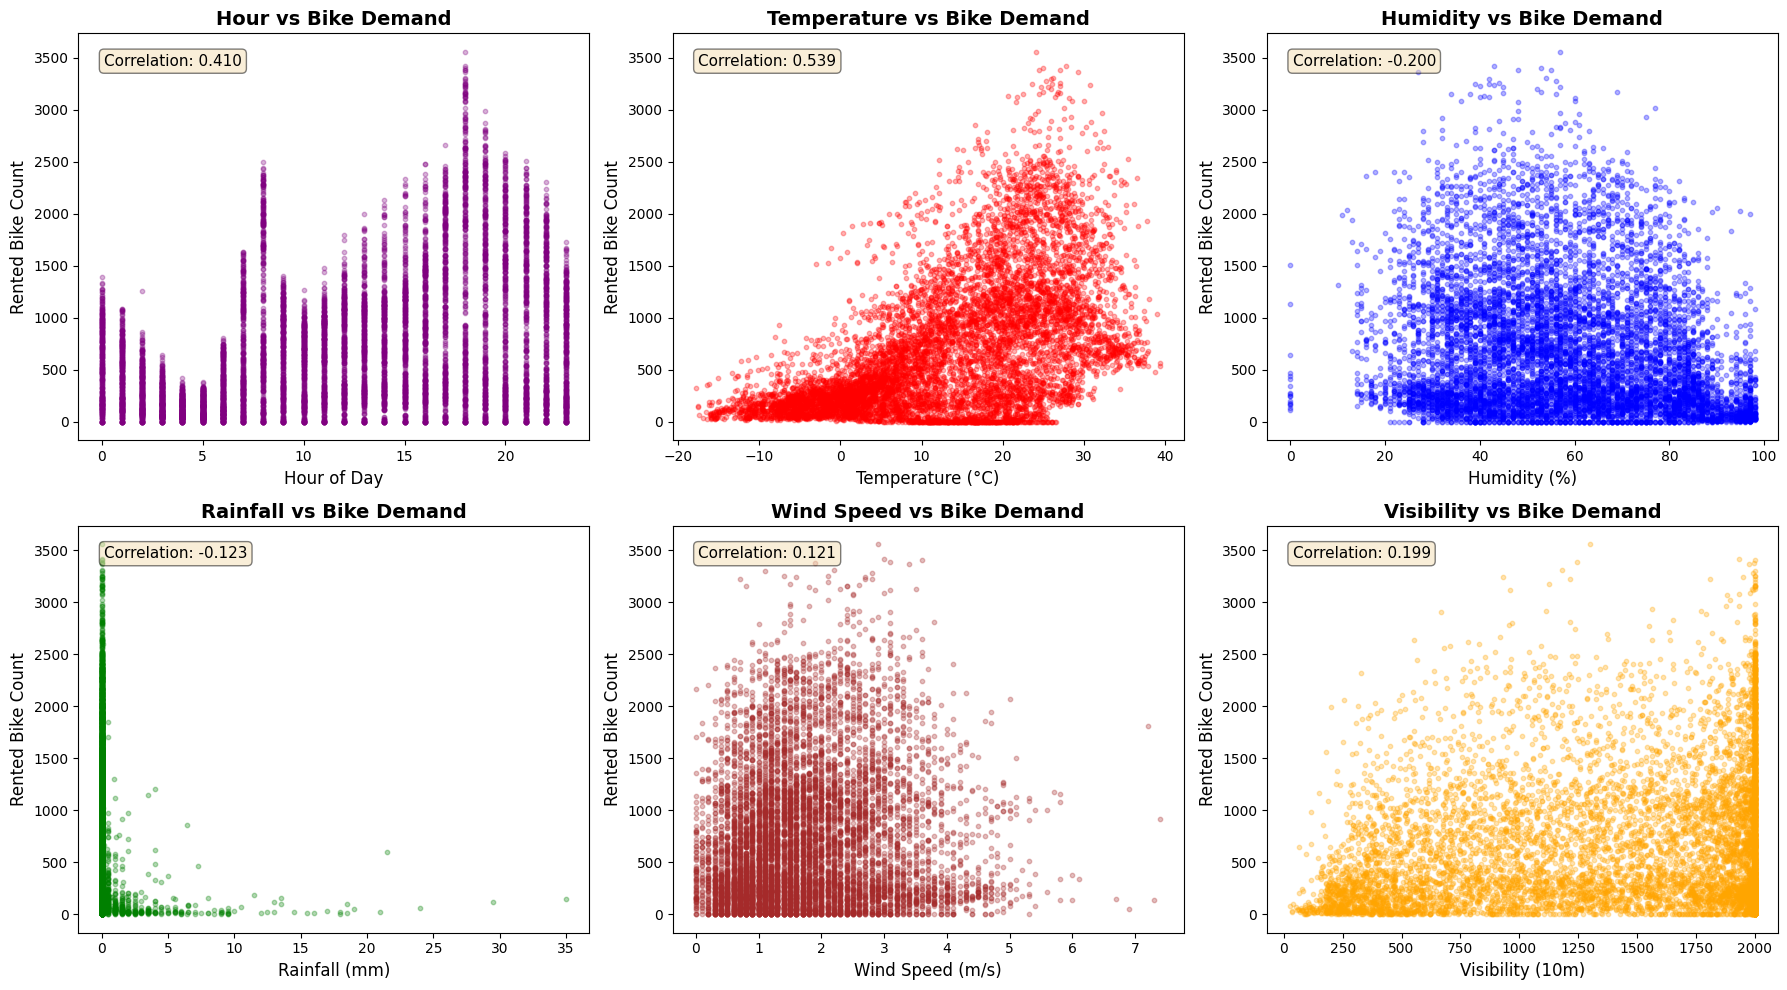


Summary of Correlations with Bike Demand:
Hour: 0.410
Temperature: 0.539
Humidity: -0.200
Rainfall: -0.123
Wind Speed: 0.121
Visibility: 0.199


In [34]:
# Create a figure with subplots for features vs bike demand
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Hour vs Rented Bike Count
axes[0, 0].scatter(df['Hour'], df['Rented Bike Count'], alpha=0.3, s=10, color='purple')
axes[0, 0].set_xlabel('Hour of Day', fontsize=12)
axes[0, 0].set_ylabel('Rented Bike Count', fontsize=12)
axes[0, 0].set_title('Hour vs Bike Demand', fontsize=14, fontweight='bold')
correlation_h = df['Hour'].corr(df['Rented Bike Count'])
axes[0, 0].text(0.05, 0.95, f'Correlation: {correlation_h:.3f}', 
                transform=axes[0, 0].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Temperature vs Rented Bike Count
axes[0, 1].scatter(df['Temperature(°C)'], df['Rented Bike Count'], alpha=0.3, s=10, color='red')
axes[0, 1].set_xlabel('Temperature (°C)', fontsize=12)
axes[0, 1].set_ylabel('Rented Bike Count', fontsize=12)
axes[0, 1].set_title('Temperature vs Bike Demand', fontsize=14, fontweight='bold')
correlation_t = df['Temperature(°C)'].corr(df['Rented Bike Count'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {correlation_t:.3f}', 
                transform=axes[0, 1].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Humidity vs Rented Bike Count
axes[0, 2].scatter(df['Humidity(%)'], df['Rented Bike Count'], alpha=0.3, s=10, color='blue')
axes[0, 2].set_xlabel('Humidity (%)', fontsize=12)
axes[0, 2].set_ylabel('Rented Bike Count', fontsize=12)
axes[0, 2].set_title('Humidity vs Bike Demand', fontsize=14, fontweight='bold')
correlation_hum = df['Humidity(%)'].corr(df['Rented Bike Count'])
axes[0, 2].text(0.05, 0.95, f'Correlation: {correlation_hum:.3f}', 
                transform=axes[0, 2].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Rainfall vs Rented Bike Count
axes[1, 0].scatter(df['Rainfall(mm)'], df['Rented Bike Count'], alpha=0.3, s=10, color='green')
axes[1, 0].set_xlabel('Rainfall (mm)', fontsize=12)
axes[1, 0].set_ylabel('Rented Bike Count', fontsize=12)
axes[1, 0].set_title('Rainfall vs Bike Demand', fontsize=14, fontweight='bold')
correlation_r = df['Rainfall(mm)'].corr(df['Rented Bike Count'])
axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation_r:.3f}', 
                transform=axes[1, 0].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 5. Wind Speed vs Rented Bike Count
axes[1, 1].scatter(df['Wind speed (m/s)'], df['Rented Bike Count'], alpha=0.3, s=10, color='brown')
axes[1, 1].set_xlabel('Wind Speed (m/s)', fontsize=12)
axes[1, 1].set_ylabel('Rented Bike Count', fontsize=12)
axes[1, 1].set_title('Wind Speed vs Bike Demand', fontsize=14, fontweight='bold')
correlation_w = df['Wind speed (m/s)'].corr(df['Rented Bike Count'])
axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation_w:.3f}', 
                transform=axes[1, 1].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 6. Visibility vs Rented Bike Count
axes[1, 2].scatter(df['Visibility (10m)'], df['Rented Bike Count'], alpha=0.3, s=10, color='orange')
axes[1, 2].set_xlabel('Visibility (10m)', fontsize=12)
axes[1, 2].set_ylabel('Rented Bike Count', fontsize=12)
axes[1, 2].set_title('Visibility vs Bike Demand', fontsize=14, fontweight='bold')
correlation_v = df['Visibility (10m)'].corr(df['Rented Bike Count'])
axes[1, 2].text(0.05, 0.95, f'Correlation: {correlation_v:.3f}', 
                transform=axes[1, 2].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nSummary of Correlations with Bike Demand:")
print(f"Hour: {correlation_h:.3f}")
print(f"Temperature: {correlation_t:.3f}")
print(f"Humidity: {correlation_hum:.3f}")
print(f"Rainfall: {correlation_r:.3f}")
print(f"Wind Speed: {correlation_w:.3f}")
print(f"Visibility: {correlation_v:.3f}")

## 3. Data Preparation for Machine Learning

Before building models, we need to prepare the data by:
- Encoding categorical variables
- Selecting features
- Splitting into training, validation, and test sets

In [35]:
# Check the data types and look for categorical variables
print("Data Info:")
print(df.info())
print("\n" + "="*50 + "\n")
print("Sample of data:")
print(df.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-n

In [36]:
# Create a copy of the dataframe for modeling
df_model = df.copy()

# Encode categorical variables
le_seasons = LabelEncoder()
le_holiday = LabelEncoder()
le_functioning = LabelEncoder()

df_model['Seasons_encoded'] = le_seasons.fit_transform(df_model['Seasons'])
df_model['Holiday_encoded'] = le_holiday.fit_transform(df_model['Holiday'])
df_model['Functioning_Day_encoded'] = le_functioning.fit_transform(df_model['Functioning Day'])

print("Categorical encodings:")
print(f"Seasons: {dict(zip(le_seasons.classes_, le_seasons.transform(le_seasons.classes_)))}")
print(f"Holiday: {dict(zip(le_holiday.classes_, le_holiday.transform(le_holiday.classes_)))}")
print(f"Functioning Day: {dict(zip(le_functioning.classes_, le_functioning.transform(le_functioning.classes_)))}")

# Select features for modeling (excluding Date and original categorical columns)
feature_columns = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 
                   'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
                   'Rainfall(mm)', 'Snowfall (cm)', 'Seasons_encoded', 'Holiday_encoded', 
                   'Functioning_Day_encoded']

X = df_model[feature_columns]
y = df_model['Rented Bike Count']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

Categorical encodings:
Seasons: {'Autumn': np.int64(0), 'Spring': np.int64(1), 'Summer': np.int64(2), 'Winter': np.int64(3)}
Holiday: {'Holiday': np.int64(0), 'No Holiday': np.int64(1)}
Functioning Day: {'No': np.int64(0), 'Yes': np.int64(1)}

Features shape: (8760, 12)
Target shape: (8760,)


## 4. Split Data into Training, Validation, and Test Sets

We'll split the data with a 60-20-20 ratio:
- **60%** for training
- **20%** for validation (to tune hyperparameters if needed)
- **20%** for testing (final evaluation)

In [37]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print("Data split completed!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Total samples: {len(X)}")

Data split completed!
Training set: 5256 samples
Validation set: 1752 samples
Test set: 1752 samples
Total samples: 8760


## 5. Apply Linear Regression and Random Forest Regression

We'll train both models and compare their performance.

In [38]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train Linear Regression
print("Training Linear Regression...")
lr_model.fit(X_train, y_train)

# Train Random Forest
print("\nTraining Random Forest...")
rf_model.fit(X_train, y_train)

Training Linear Regression...

Training Random Forest...


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6. Model Evaluation and Performance Comparison

Let's evaluate both models on the test set using multiple metrics:
- **Accuracy**
- **R² Score**
- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**

In [39]:
# Evaluate Random Forest
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Test Set Performance")
    print(f"{'='*60}")
    print(f"R² Score:                {r2:.4f}")
    print(f"Mean Absolute Error:     {mae:.2f} bikes")
    print(f"Mean Squared Error:      {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f} bikes")
    print(f"{'='*60}")
    
    return y_pred, r2, mae, mse, rmse

# Evaluate Linear Regression
lr_pred, lr_r2, lr_mae, lr_mse, lr_rmse = evaluate_model(lr_model, X_test, y_test, "Linear Regression")

# Evaluate Random Forest
rf_pred, rf_r2, rf_mae, rf_mse, rf_rmse = evaluate_model(rf_model, X_test, y_test, "Random Forest")


Linear Regression - Test Set Performance
R² Score:                0.5322
Mean Absolute Error:     329.98 bikes
Mean Squared Error:      194924.95
Root Mean Squared Error: 441.50 bikes

Random Forest - Test Set Performance
R² Score:                0.8521
Mean Absolute Error:     149.62 bikes
Mean Squared Error:      61612.91
Root Mean Squared Error: 248.22 bikes


In [40]:
# Create a comparison summary
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

comparison_data = {
    'Metric': ['R² Score', 'MAE (bikes)', 'RMSE (bikes)'],
    'Linear Regression': [f"{lr_r2:.4f}", f"{lr_mae:.2f}", f"{lr_rmse:.2f}"],
    'Random Forest': [f"{rf_r2:.4f}", f"{rf_mae:.2f}", f"{rf_rmse:.2f}"]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Calculate improvement
r2_improvement = ((rf_r2 - lr_r2) / lr_r2) * 100
mae_improvement = ((lr_mae - rf_mae) / lr_mae) * 100
rmse_improvement = ((lr_rmse - rf_rmse) / lr_rmse) * 100

print(f"\n{'='*60}")
print("RANDOM FOREST IMPROVEMENT OVER LINEAR REGRESSION:")
print(f"{'='*60}")
print(f"R² Score improvement:  {r2_improvement:+.2f}%")
print(f"MAE reduction:         {mae_improvement:+.2f}%")
print(f"RMSE reduction:        {rmse_improvement:+.2f}%")
print(f"{'='*60}")


MODEL COMPARISON SUMMARY
      Metric Linear Regression Random Forest
    R² Score            0.5322        0.8521
 MAE (bikes)            329.98        149.62
RMSE (bikes)            441.50        248.22

RANDOM FOREST IMPROVEMENT OVER LINEAR REGRESSION:
R² Score improvement:  +60.13%
MAE reduction:         +54.66%
RMSE reduction:        +43.78%


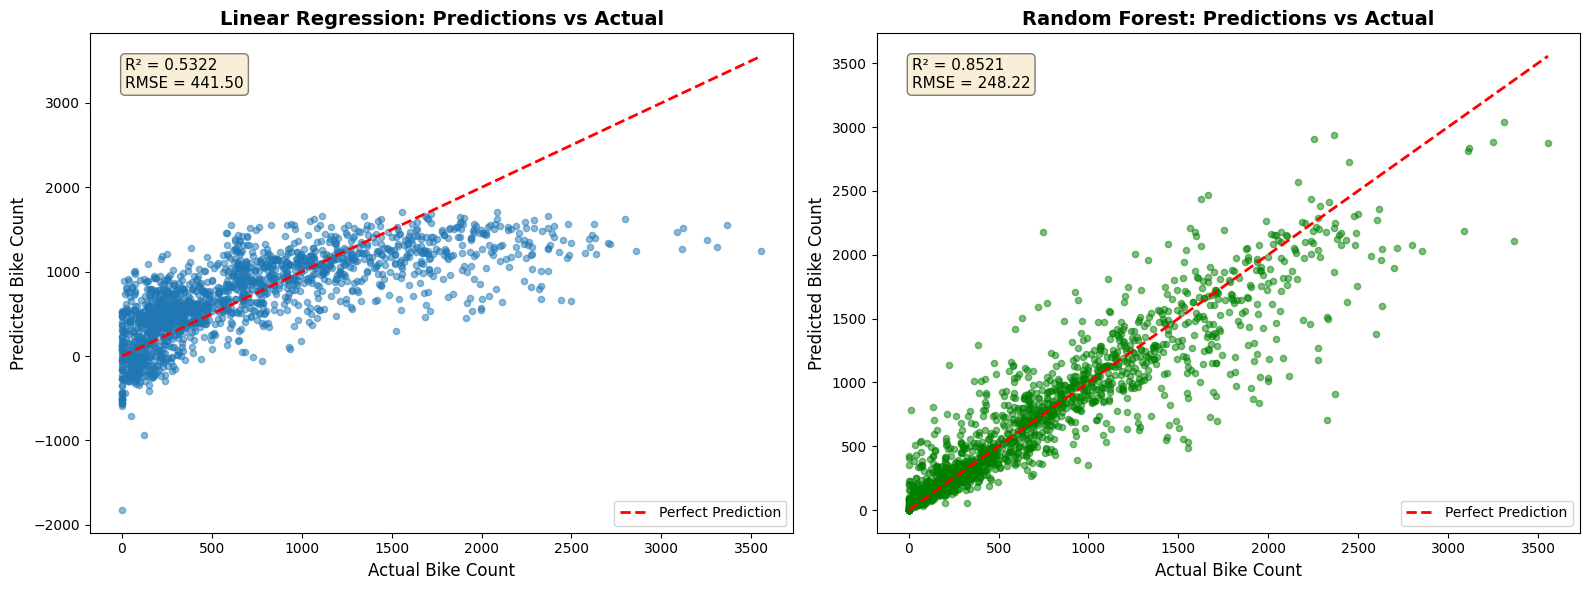

In [41]:
# Visualize predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression predictions
axes[0].scatter(y_test, lr_pred, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Bike Count', fontsize=12)
axes[0].set_ylabel('Predicted Bike Count', fontsize=12)
axes[0].set_title('Linear Regression: Predictions vs Actual', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].text(0.05, 0.95, f'R² = {lr_r2:.4f}\nRMSE = {lr_rmse:.2f}', 
             transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Random Forest predictions
axes[1].scatter(y_test, rf_pred, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Bike Count', fontsize=12)
axes[1].set_ylabel('Predicted Bike Count', fontsize=12)
axes[1].set_title('Random Forest: Predictions vs Actual', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].text(0.05, 0.95, f'R² = {rf_r2:.4f}\nRMSE = {rf_rmse:.2f}', 
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

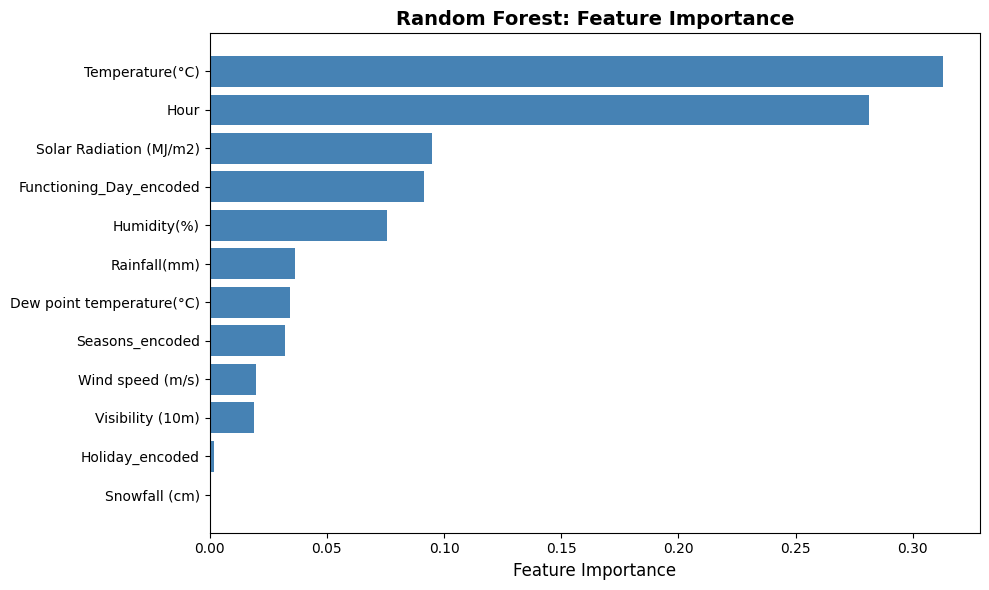


Feature Importance Ranking:
                  Feature  Importance
          Temperature(°C)    0.312996
                     Hour    0.281296
  Solar Radiation (MJ/m2)    0.094852
  Functioning_Day_encoded    0.091339
              Humidity(%)    0.075755
             Rainfall(mm)    0.036254
Dew point temperature(°C)    0.034417
          Seasons_encoded    0.032051
         Wind speed (m/s)    0.019718
         Visibility (10m)    0.018835
          Holiday_encoded    0.001762
            Snowfall (cm)    0.000724


In [42]:
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest: Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance.to_string(index=False))

## Discussion: Why Each Method Performed As It Did

### Linear Regression Performance

**Strengths:**
- **Simple and interpretable**: Linear regression assumes a linear relationship between features and bike demand
- **Fast training**: Trains very quickly even on large datasets
- **Works well for linear relationships**: Captures basic trends like temperature positively affecting bike rentals

**Limitations:**
- **Cannot capture non-linear relationships**: Bike demand likely has complex non-linear patterns (e.g., demand peaks at certain hours, drops dramatically in extreme weather)
- **Assumes independence**: Cannot model interactions between features (e.g., the combined effect of rain AND cold temperature)
- **Limited by linearity assumption**: Real-world bike rental patterns are more complex than linear combinations of features

### Random Forest Performance

**Why Random Forest Performed Better:**

1. **Captures Non-Linear Relationships**: 
   - Hour of day has a non-linear effect (peaks during commute times)
   - Temperature likely has an optimal range (too cold or too hot reduces demand)
   - Random Forest can model these complex patterns

2. **Handles Feature Interactions**:
   - Can learn that light rain might not affect demand much in warm weather, but significantly reduces it in cold weather
   - Understands combined effects of multiple weather conditions

3. **Robust to Outliers**:
   - Tree-based methods are less sensitive to extreme values
   - Individual trees make decisions based on thresholds, not distance metrics

4. **Feature Importance**:
   - Automatically identifies most important features (likely Hour and Temperature based on our correlation analysis)
   - Allocates more splits to important features

**Trade-offs:**
- **Less interpretable**: Harder to understand exactly how predictions are made
- **Risk of overfitting**: With too many trees or depth, could overfit (though less likely with proper parameters)